# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [1]:
# 程式區塊 A
# 將需要的都import進來
import os
import copy
import time
import math
import numpy             as np
import pandas            as pd
import seaborn           as sns
import datetime          as dt
import warnings
import matplotlib.pyplot as plt
from scipy                   import stats
from itertools               import compress
from sklearn.metrics         import roc_curve
from sklearn.ensemble        import GradientBoostingRegressor,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model    import LogisticRegression,LinearRegression,Lasso
from sklearn.preprocessing   import LabelEncoder, MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score,train_test_split



# 將較長的函式改名一下
MME  = MinMaxScaler()
LE   = LabelEncoder()
LR   = LogisticRegression()
LIR  = LinearRegression()
GBR  = GradientBoostingRegressor()
GBC  = GradientBoostingClassifier()
RFC  = RandomForestClassifier()
OHE  = OneHotEncoder()

PDDF = pd.DataFrame()
# 一些必要的設定
warnings.filterwarnings('ignore')
%matplotlib inline

# 設定【data的資料夾路徑】，命名為【data_folder】
data_folder = 'C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data'

In [2]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_train = os.path.join(data_folder, 'titanic_train.csv')
t002_train = pd.read_csv(t001_train)
print('Path of read in data: %s' %t001_train)
print(t002_train.shape)
t002_train.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_train.csv
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_test  = os.path.join(data_folder,  'titanic_test.csv')
t002_test  = pd.read_csv(t001_test)
print('Path of read in data: %s' %t001_test)
print(t002_test.shape)
t002_test.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_test.csv
(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# 程式區塊 B-1：train取【Survived】為Y、test取【PassengerId】為最終將比對的唯一識別
train_Y_t1  = t002_train['Survived']
test_unique     = t002_test['PassengerId']
# 程式區塊 B-2：train捨棄【PassengerId,Survived】、test捨棄【PassengerId】。
t003_train = t002_train.drop(['PassengerId', 'Survived'] , axis=1)
t003_test  = t002_test.drop(['PassengerId'] , axis=1)
print(t003_train.shape)
print(t003_test.shape)

(891, 10)
(418, 10)


In [5]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
for d in t003_train.columns:
    t003_train[d] = t003_train[d].fillna(-1)
    if t003_train[d].dtype == 'object':
        t003_train[d] = LE.fit_transform(list(t003_train[d].values))
    t003_train[d] = MME.fit_transform(t003_train[d].values.reshape(-1, 1))
print(t003_train.shape)    
t003_train.head()

(891, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [6]:
# 先將【t003_train】數值化，就是用array的方式列出所有數據，總共有891*10個數據，看【t004_train】的結果可知。
train_X_t1 = t003_train.values
print(train_X_t1.shape)
train_X_t1

(891, 10)


array([[1.        , 0.12134831, 1.        , ..., 0.01415106, 0.        ,
        1.        ],
       [0.        , 0.21348315, 0.        , ..., 0.13913574, 0.55782313,
        0.33333333],
       [1.        , 0.39662921, 0.        , ..., 0.01546857, 0.        ,
        1.        ],
       ...,
       [1.        , 0.46404494, 0.        , ..., 0.04577135, 0.        ,
        1.        ],
       [0.        , 0.09101124, 1.        , ..., 0.0585561 , 0.41496599,
        0.33333333],
       [1.        , 0.24719101, 1.        , ..., 0.01512699, 0.        ,
        0.66666667]])

下一步將運用【train_test_split】來拆解出四個東西，且很顯然此四個東西，和【titanic_test.csv】這份資料是無關的。  
原因？為什麼不拿test來用，而要從train裡面拆出test？一如往常地沒有說明，只能猜測。  

應該是【titanic_test.csv】這份資料沒有【Survived】，顯然沒有結果，無法驗證模型正確度，  
所以現階段先拿有【Survived】結果的【titanic_train.csv】來拆解，  
拿一部份的資料當製作模型的訓練資料，拿一部分當作來驗證模型的測試資料和驗證資料，  
所以教材中train_test_split(train_X, train_Y, test_size=0.2)裡面寫著【train_X, train_Y】顯然會讓人混淆，  
畢竟這不是真要拿來使用的【train_X, train_Y】，  
因此我的概念是，將【train_X_t1】拆成【train_X_t2】、【test_X】；將【train_Y_t1】拆成【train_Y_t2】、【test_Y】。  
這邊重點是要先將【test_X】和【test_Y】給做出來。

那test要幾筆呢？就是看test_size，891筆乘上多少？0.2，那就是179囉~
所以train還會有712筆、而test會有179筆。
X有10個欄位
Y都只有Survived結果1個欄位

In [7]:
train_X_t2, test_X, train_Y_t2, test_Y = train_test_split(train_X_t1, train_Y_t1, test_size=0.2)
print(train_X_t2.shape)
print(test_X.shape)
print(train_Y_t2.shape)
print(test_Y.shape)
train_X_t2

(712, 10)
(179, 10)
(712,)
(179,)


array([[1.        , 0.11348315, 1.        , ..., 0.03025399, 0.        ,
        0.66666667],
       [0.5       , 0.08539326, 1.        , ..., 0.07612293, 0.98639456,
        1.        ],
       [0.5       , 0.16516854, 1.        , ..., 0.05074862, 0.        ,
        1.        ],
       ...,
       [0.        , 0.2988764 , 0.        , ..., 0.09661757, 0.19047619,
        0.33333333],
       [0.        , 0.57078652, 1.        , ..., 0.05797054, 0.46938776,
        0.33333333],
       [1.        , 0.62808989, 1.        , ..., 0.01517579, 0.        ,
        1.        ]])

再拆一次！真正的train_X和train_Y才真的被我們做出來，
712筆資料，一樣撥0.25給validation，也就是178筆。終於，我們把891筆資料，拆成：
1. train      訓練資料 534筆
2. test       測試資料 179筆
3. validation 驗證資料 178筆

In [8]:
train_X, val_X, train_Y, val_Y = train_test_split(train_X_t2, train_Y_t2, test_size=0.25)
print(train_X.shape)
print(val_X.shape)
print(train_Y.shape)
print(val_Y.shape)

(534, 10)
(178, 10)
(534,)
(178,)


In [9]:
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)
print(train_Y.shape)
print(test_Y.shape)
print(val_Y.shape)

(534, 10)
(179, 10)
(178, 10)
(534,)
(179,)
(178,)


### 至此供機器學習的三段資料(訓練、測試、驗證)準備好了

# 作業1
* 請對照範例，完成[隨機森林](https://blog.csdn.net/u012102306/article/details/52228516)的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸
* [社群提問](https://www.cupoy.com/qa/kwassist/ai_tw/0000016AC4811CB7000001056375706F795F72656C656173655155455354)

In [10]:
# 隨機森林的使用：
# 1.先設計全部的參數，並把設定好全部參數的隨機森林函式做命名，此例命名為rf
# 2.再告訴rf我們要使用的【X,Y】是什麼
rf = RandomForestClassifier(
    n_estimators      = 20, #要做幾棵樹出來？
    min_samples_split = 10, #拆前至少要有幾個樣本，才能再繼續被某特徵給劃分，例如若拆前只剩下9個樣本，就不會再拆了。
    min_samples_leaf  =  5, #拆完至少要有幾個樣本，才能再繼續被某特徵給劃分，例如若拆完只剩下6和4個樣本，縱使符合拆前有10個樣本，它仍然不會進行拆分。
    max_features      = 10, #每次做劃分，最多拿幾個特徵來考慮？並不會直接影響劃分的群數。
    max_depth         =  3, #樹的高度要多高，換句話說每一層要拆幾次，
                            #根據測試，max_depth=1時，只會有1或2兩種可能，但max_depth=2時，卻可能有1~6種可能，表示第二層拆成三類，(把1,2拆成1~6)                    
    bootstrap         = True)
rf.fit(train_X, train_Y)
# 換句話說，RandomForestClassifier其實做了兩件事：先指定好所有參數，再指定要使用的【X,Y】。
# 但是，並沒有一個簡單的方法，可以讓我們發現有沒有做2這件事，因為縱使印出，也只會印出相同的參數，
# 而不會印出有關【fit前,fit後】的差異，必須等後面用了才知道有沒有問題。
# 所以現階段，反正就是先把這兩個動作記下來。

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
print(rf.apply(train_X)[0]) 
print(rf.apply(train_X)[1]) 
print(rf.apply(train_X)[2]) 
print(rf.apply(train_X)[3]) 
print(rf.apply(train_X)[4]) 
print(rf.apply(train_X)[5]) 
print(rf.apply(train_X)[6]) 
print(rf.apply(train_X)[7]) 
print(rf.apply(train_X)[8]) 
print(rf.apply(train_X)[9]) 
print(rf.apply(train_X)[10]) 
print(rf.apply(train_X)[11]) 
print(rf.apply(train_X)[12]) 
print(rf.apply(train_X)[13]) 
print(rf.apply(train_X)[14]) 
print(rf.apply(train_X)[15]) 
print(rf.apply(train_X)[16]) 
print(rf.apply(train_X)[17]) 
print(rf.apply(train_X)[18]) 
print(rf.apply(train_X)[19]) 
print(rf.apply(train_X)[20]) 
print(rf.apply(train_X)[21]) 
print(rf.apply(train_X)[22]) 
print(rf.apply(train_X)[23]) 
print(rf.apply(train_X)[24]) 
print(rf.apply(train_X)[25]) 
print(rf.apply(train_X)[26]) 
print(rf.apply(train_X)[27]) 
print(rf.apply(train_X)[28]) 
print(rf.apply(train_X)[29]) 
print(rf.apply(train_X)[30]) 
print(rf.apply(train_X)[31]) 
print(rf.apply(train_X)[32]) 
print(rf.apply(train_X)[33]) 
print(rf.apply(train_X)[34]) 
print(rf.apply(train_X)[35]) 
print(rf.apply(train_X)[36]) 
print(rf.apply(train_X)[37]) 
print(rf.apply(train_X)[38]) 
print(rf.apply(train_X)[39]) 
print(rf.apply(train_X)[40]) 
print(rf.apply(train_X)[41]) 
print(rf.apply(train_X)[42]) 
print(rf.apply(train_X)[43]) 
print(rf.apply(train_X)[44]) 
print(rf.apply(train_X)[45]) 
print(rf.apply(train_X)[46]) 
print(rf.apply(train_X)[47]) 
print(rf.apply(train_X)[48]) 
print(rf.apply(train_X)[49]) 
print(rf.apply(train_X)[50]) 
print(rf.apply(train_X)[51]) 
print(rf.apply(train_X)[52]) 
print(rf.apply(train_X)[53]) 
print(rf.apply(train_X)[54]) 
print(rf.apply(train_X)[55]) 
print(rf.apply(train_X)[56]) 
print(rf.apply(train_X)[57]) 
print(rf.apply(train_X)[58]) 
print(rf.apply(train_X)[59]) 
print(rf.apply(train_X)[60]) 
print(rf.apply(train_X)[61]) 
print(rf.apply(train_X)[62]) 
print(rf.apply(train_X)[63]) 
print(rf.apply(train_X)[64]) 
print(rf.apply(train_X)[65]) 
print(rf.apply(train_X)[66]) 
print(rf.apply(train_X)[67]) 
print(rf.apply(train_X)[68]) 
print(rf.apply(train_X)[69]) 
print(rf.apply(train_X)[70]) 
print(rf.apply(train_X)[71]) 
print(rf.apply(train_X)[72]) 
print(rf.apply(train_X)[73]) 
print(rf.apply(train_X)[74]) 
print(rf.apply(train_X)[75]) 
print(rf.apply(train_X)[76]) 
print(rf.apply(train_X)[77]) 
print(rf.apply(train_X)[78]) 
print(rf.apply(train_X)[79]) 
print(rf.apply(train_X)[80]) 
print(rf.apply(train_X)[81]) 
print(rf.apply(train_X)[82]) 
print(rf.apply(train_X)[83]) 
print(rf.apply(train_X)[84]) 
print(rf.apply(train_X)[85]) 
print(rf.apply(train_X)[86]) 
print(rf.apply(train_X)[87]) 
print(rf.apply(train_X)[88]) 
print(rf.apply(train_X)[89]) 
print(rf.apply(train_X)[90]) 
print(rf.apply(train_X)[91]) 
print(rf.apply(train_X)[92]) 
print(rf.apply(train_X)[93]) 
print(rf.apply(train_X)[94]) 
print(rf.apply(train_X)[95]) 
print(rf.apply(train_X)[96]) 
print(rf.apply(train_X)[97]) 
print(rf.apply(train_X)[98]) 
print(rf.apply(train_X)[99]) 
print(rf.apply(train_X)[100]) 
print(rf.apply(train_X)[101]) 
print(rf.apply(train_X)[102]) 
print(rf.apply(train_X)[103]) 
print(rf.apply(train_X)[104]) 
print(rf.apply(train_X)[105]) 
print(rf.apply(train_X)[106]) 
print(rf.apply(train_X)[107]) 
print(rf.apply(train_X)[108]) 
print(rf.apply(train_X)[109]) 
print(rf.apply(train_X)[110]) 
print(rf.apply(train_X)[111]) 
print(rf.apply(train_X)[112]) 
print(rf.apply(train_X)[113]) 
print(rf.apply(train_X)[114]) 
print(rf.apply(train_X)[115]) 
print(rf.apply(train_X)[116]) 
print(rf.apply(train_X)[117]) 
print(rf.apply(train_X)[118]) 
print(rf.apply(train_X)[119]) 
print(rf.apply(train_X)[120]) 
print(rf.apply(train_X)[121]) 
print(rf.apply(train_X)[122]) 
print(rf.apply(train_X)[123]) 
print(rf.apply(train_X)[124]) 
print(rf.apply(train_X)[125]) 
print(rf.apply(train_X)[126]) 
print(rf.apply(train_X)[127]) 
print(rf.apply(train_X)[128]) 
print(rf.apply(train_X)[129]) 
print(rf.apply(train_X)[130]) 
print(rf.apply(train_X)[131]) 
print(rf.apply(train_X)[132]) 
print(rf.apply(train_X)[133]) 
print(rf.apply(train_X)[134]) 
print(rf.apply(train_X)[135]) 
print(rf.apply(train_X)[136]) 
print(rf.apply(train_X)[137]) 
print(rf.apply(train_X)[138]) 
print(rf.apply(train_X)[139]) 
print(rf.apply(train_X)[140]) 
print(rf.apply(train_X)[141]) 
print(rf.apply(train_X)[142]) 
print(rf.apply(train_X)[143]) 
print(rf.apply(train_X)[144]) 
print(rf.apply(train_X)[145]) 
print(rf.apply(train_X)[146]) 
print(rf.apply(train_X)[147]) 
print(rf.apply(train_X)[148]) 
print(rf.apply(train_X)[149]) 
print(rf.apply(train_X)[150]) 
print(rf.apply(train_X)[151]) 
print(rf.apply(train_X)[152]) 
print(rf.apply(train_X)[153]) 
print(rf.apply(train_X)[154]) 
print(rf.apply(train_X)[155]) 
print(rf.apply(train_X)[156]) 
print(rf.apply(train_X)[157]) 
print(rf.apply(train_X)[158]) 
print(rf.apply(train_X)[159]) 
print(rf.apply(train_X)[160]) 
print(rf.apply(train_X)[161]) 
print(rf.apply(train_X)[162]) 
print(rf.apply(train_X)[163]) 
print(rf.apply(train_X)[164]) 
print(rf.apply(train_X)[165]) 
print(rf.apply(train_X)[166]) 
print(rf.apply(train_X)[167]) 
print(rf.apply(train_X)[168]) 
print(rf.apply(train_X)[169]) 
print(rf.apply(train_X)[170]) 
print(rf.apply(train_X)[171]) 
print(rf.apply(train_X)[172]) 
print(rf.apply(train_X)[173]) 
print(rf.apply(train_X)[174]) 
print(rf.apply(train_X)[175]) 
print(rf.apply(train_X)[176]) 
print(rf.apply(train_X)[177]) 
print(rf.apply(train_X)[178]) 
print(rf.apply(train_X)[179]) 
print(rf.apply(train_X)[180]) 
print(rf.apply(train_X)[181]) 
print(rf.apply(train_X)[182]) 
print(rf.apply(train_X)[183]) 
print(rf.apply(train_X)[184]) 
print(rf.apply(train_X)[185]) 
print(rf.apply(train_X)[186]) 
print(rf.apply(train_X)[187]) 
print(rf.apply(train_X)[188]) 
print(rf.apply(train_X)[189]) 
print(rf.apply(train_X)[190]) 
print(rf.apply(train_X)[191]) 
print(rf.apply(train_X)[192]) 
print(rf.apply(train_X)[193]) 
print(rf.apply(train_X)[194]) 
print(rf.apply(train_X)[195]) 
print(rf.apply(train_X)[196]) 
print(rf.apply(train_X)[197]) 
print(rf.apply(train_X)[198]) 
print(rf.apply(train_X)[199]) 
print(rf.apply(train_X)[200]) 
print(rf.apply(train_X)[201]) 
print(rf.apply(train_X)[202]) 
print(rf.apply(train_X)[203]) 
print(rf.apply(train_X)[204]) 
print(rf.apply(train_X)[205]) 
print(rf.apply(train_X)[206]) 
print(rf.apply(train_X)[207]) 
print(rf.apply(train_X)[208]) 
print(rf.apply(train_X)[209]) 
print(rf.apply(train_X)[210]) 
print(rf.apply(train_X)[211]) 
print(rf.apply(train_X)[212]) 
print(rf.apply(train_X)[213]) 
print(rf.apply(train_X)[214]) 
print(rf.apply(train_X)[215]) 
print(rf.apply(train_X)[216]) 
print(rf.apply(train_X)[217]) 
print(rf.apply(train_X)[218]) 
print(rf.apply(train_X)[219]) 
print(rf.apply(train_X)[220]) 
print(rf.apply(train_X)[221]) 
print(rf.apply(train_X)[222]) 
print(rf.apply(train_X)[223]) 
print(rf.apply(train_X)[224]) 
print(rf.apply(train_X)[225]) 
print(rf.apply(train_X)[226]) 
print(rf.apply(train_X)[227]) 
print(rf.apply(train_X)[228]) 
print(rf.apply(train_X)[229]) 
print(rf.apply(train_X)[230]) 
print(rf.apply(train_X)[231]) 
print(rf.apply(train_X)[232]) 
print(rf.apply(train_X)[233]) 
print(rf.apply(train_X)[234]) 
print(rf.apply(train_X)[235]) 
print(rf.apply(train_X)[236]) 
print(rf.apply(train_X)[237]) 
print(rf.apply(train_X)[238]) 
print(rf.apply(train_X)[239]) 
print(rf.apply(train_X)[240]) 
print(rf.apply(train_X)[241]) 
print(rf.apply(train_X)[242]) 
print(rf.apply(train_X)[243]) 
print(rf.apply(train_X)[244]) 
print(rf.apply(train_X)[245]) 
print(rf.apply(train_X)[246]) 
print(rf.apply(train_X)[247]) 
print(rf.apply(train_X)[248]) 
print(rf.apply(train_X)[249]) 
print(rf.apply(train_X)[250]) 
print(rf.apply(train_X)[251]) 
print(rf.apply(train_X)[252]) 
print(rf.apply(train_X)[253]) 
print(rf.apply(train_X)[254]) 
print(rf.apply(train_X)[255]) 
print(rf.apply(train_X)[256]) 
print(rf.apply(train_X)[257]) 
print(rf.apply(train_X)[258]) 
print(rf.apply(train_X)[259]) 
print(rf.apply(train_X)[260]) 
print(rf.apply(train_X)[261]) 
print(rf.apply(train_X)[262]) 
print(rf.apply(train_X)[263]) 
print(rf.apply(train_X)[264]) 
print(rf.apply(train_X)[265]) 
print(rf.apply(train_X)[266]) 
print(rf.apply(train_X)[267]) 
print(rf.apply(train_X)[268]) 
print(rf.apply(train_X)[269]) 
print(rf.apply(train_X)[270]) 
print(rf.apply(train_X)[271]) 
print(rf.apply(train_X)[272]) 
print(rf.apply(train_X)[273]) 
print(rf.apply(train_X)[274]) 
print(rf.apply(train_X)[275]) 
print(rf.apply(train_X)[276]) 
print(rf.apply(train_X)[277]) 
print(rf.apply(train_X)[278]) 
print(rf.apply(train_X)[279]) 
print(rf.apply(train_X)[280]) 
print(rf.apply(train_X)[281]) 
print(rf.apply(train_X)[282]) 
print(rf.apply(train_X)[283]) 
print(rf.apply(train_X)[284]) 
print(rf.apply(train_X)[285]) 
print(rf.apply(train_X)[286]) 
print(rf.apply(train_X)[287]) 
print(rf.apply(train_X)[288]) 
print(rf.apply(train_X)[289]) 
print(rf.apply(train_X)[290]) 
print(rf.apply(train_X)[291]) 
print(rf.apply(train_X)[292]) 
print(rf.apply(train_X)[293]) 
print(rf.apply(train_X)[294]) 
print(rf.apply(train_X)[295]) 
print(rf.apply(train_X)[296]) 
print(rf.apply(train_X)[297]) 
print(rf.apply(train_X)[298]) 
print(rf.apply(train_X)[299]) 
print(rf.apply(train_X)[300]) 
print(rf.apply(train_X)[301]) 
print(rf.apply(train_X)[302]) 
print(rf.apply(train_X)[303]) 
print(rf.apply(train_X)[304]) 
print(rf.apply(train_X)[305]) 
print(rf.apply(train_X)[306]) 
print(rf.apply(train_X)[307]) 
print(rf.apply(train_X)[308]) 
print(rf.apply(train_X)[309]) 
print(rf.apply(train_X)[310]) 
print(rf.apply(train_X)[311]) 
print(rf.apply(train_X)[312]) 
print(rf.apply(train_X)[313]) 
print(rf.apply(train_X)[314]) 
print(rf.apply(train_X)[315]) 
print(rf.apply(train_X)[316]) 
print(rf.apply(train_X)[317]) 
print(rf.apply(train_X)[318]) 
print(rf.apply(train_X)[319]) 
print(rf.apply(train_X)[320]) 
print(rf.apply(train_X)[321]) 
print(rf.apply(train_X)[322]) 
print(rf.apply(train_X)[323]) 
print(rf.apply(train_X)[324]) 
print(rf.apply(train_X)[325]) 
print(rf.apply(train_X)[326]) 
print(rf.apply(train_X)[327]) 
print(rf.apply(train_X)[328]) 
print(rf.apply(train_X)[329]) 
print(rf.apply(train_X)[330]) 
print(rf.apply(train_X)[331]) 
print(rf.apply(train_X)[332]) 
print(rf.apply(train_X)[333]) 
print(rf.apply(train_X)[334]) 
print(rf.apply(train_X)[335]) 
print(rf.apply(train_X)[336]) 
print(rf.apply(train_X)[337]) 
print(rf.apply(train_X)[338]) 
print(rf.apply(train_X)[339]) 
print(rf.apply(train_X)[340]) 
print(rf.apply(train_X)[341]) 
print(rf.apply(train_X)[342]) 
print(rf.apply(train_X)[343]) 
print(rf.apply(train_X)[344]) 
print(rf.apply(train_X)[345]) 
print(rf.apply(train_X)[346]) 
print(rf.apply(train_X)[347]) 
print(rf.apply(train_X)[348]) 
print(rf.apply(train_X)[349]) 
print(rf.apply(train_X)[350]) 
print(rf.apply(train_X)[351]) 
print(rf.apply(train_X)[352]) 
print(rf.apply(train_X)[353]) 
print(rf.apply(train_X)[354]) 
print(rf.apply(train_X)[355]) 
print(rf.apply(train_X)[356]) 
print(rf.apply(train_X)[357]) 
print(rf.apply(train_X)[358]) 
print(rf.apply(train_X)[359]) 
print(rf.apply(train_X)[360]) 
print(rf.apply(train_X)[361]) 
print(rf.apply(train_X)[362]) 
print(rf.apply(train_X)[363]) 
print(rf.apply(train_X)[364]) 
print(rf.apply(train_X)[365]) 
print(rf.apply(train_X)[366]) 
print(rf.apply(train_X)[367]) 
print(rf.apply(train_X)[368]) 
print(rf.apply(train_X)[369]) 
print(rf.apply(train_X)[370]) 
print(rf.apply(train_X)[371]) 
print(rf.apply(train_X)[372]) 
print(rf.apply(train_X)[373]) 
print(rf.apply(train_X)[374]) 
print(rf.apply(train_X)[375]) 
print(rf.apply(train_X)[376]) 
print(rf.apply(train_X)[377]) 
print(rf.apply(train_X)[378]) 
print(rf.apply(train_X)[379]) 
print(rf.apply(train_X)[380]) 
print(rf.apply(train_X)[381]) 
print(rf.apply(train_X)[382]) 
print(rf.apply(train_X)[383]) 
print(rf.apply(train_X)[384]) 
print(rf.apply(train_X)[385]) 
print(rf.apply(train_X)[386]) 
print(rf.apply(train_X)[387]) 
print(rf.apply(train_X)[388]) 
print(rf.apply(train_X)[389]) 
print(rf.apply(train_X)[390]) 
print(rf.apply(train_X)[391]) 
print(rf.apply(train_X)[392]) 
print(rf.apply(train_X)[393]) 
print(rf.apply(train_X)[394]) 
print(rf.apply(train_X)[395]) 
print(rf.apply(train_X)[396]) 
print(rf.apply(train_X)[397]) 
print(rf.apply(train_X)[398]) 
print(rf.apply(train_X)[399]) 
print(rf.apply(train_X)[400]) 
print(rf.apply(train_X)[401]) 
print(rf.apply(train_X)[402]) 
print(rf.apply(train_X)[403]) 
print(rf.apply(train_X)[404]) 
print(rf.apply(train_X)[405]) 
print(rf.apply(train_X)[406]) 
print(rf.apply(train_X)[407]) 
print(rf.apply(train_X)[408]) 
print(rf.apply(train_X)[409]) 
print(rf.apply(train_X)[410]) 
print(rf.apply(train_X)[411]) 
print(rf.apply(train_X)[412]) 
print(rf.apply(train_X)[413]) 
print(rf.apply(train_X)[414]) 
print(rf.apply(train_X)[415]) 
print(rf.apply(train_X)[416]) 
print(rf.apply(train_X)[417]) 
print(rf.apply(train_X)[418]) 
print(rf.apply(train_X)[419]) 
print(rf.apply(train_X)[420]) 
print(rf.apply(train_X)[421]) 
print(rf.apply(train_X)[422]) 
print(rf.apply(train_X)[423]) 
print(rf.apply(train_X)[424]) 
print(rf.apply(train_X)[425]) 
print(rf.apply(train_X)[426]) 
print(rf.apply(train_X)[427]) 
print(rf.apply(train_X)[428]) 
print(rf.apply(train_X)[429]) 
print(rf.apply(train_X)[430]) 
print(rf.apply(train_X)[431]) 
print(rf.apply(train_X)[432]) 
print(rf.apply(train_X)[433]) 
print(rf.apply(train_X)[434]) 
print(rf.apply(train_X)[435]) 
print(rf.apply(train_X)[436]) 
print(rf.apply(train_X)[437]) 
print(rf.apply(train_X)[438]) 
print(rf.apply(train_X)[439]) 
print(rf.apply(train_X)[440]) 
print(rf.apply(train_X)[441]) 
print(rf.apply(train_X)[442]) 
print(rf.apply(train_X)[443]) 
print(rf.apply(train_X)[444]) 
print(rf.apply(train_X)[445]) 
print(rf.apply(train_X)[446]) 
print(rf.apply(train_X)[447]) 
print(rf.apply(train_X)[448]) 
print(rf.apply(train_X)[449]) 
print(rf.apply(train_X)[450]) 
print(rf.apply(train_X)[451]) 
print(rf.apply(train_X)[452]) 
print(rf.apply(train_X)[453]) 
print(rf.apply(train_X)[454]) 
print(rf.apply(train_X)[455]) 
print(rf.apply(train_X)[456]) 
print(rf.apply(train_X)[457]) 
print(rf.apply(train_X)[458]) 
print(rf.apply(train_X)[459]) 
print(rf.apply(train_X)[460]) 
print(rf.apply(train_X)[461]) 
print(rf.apply(train_X)[462]) 
print(rf.apply(train_X)[463]) 
print(rf.apply(train_X)[464]) 
print(rf.apply(train_X)[465]) 
print(rf.apply(train_X)[466]) 
print(rf.apply(train_X)[467]) 
print(rf.apply(train_X)[468]) 
print(rf.apply(train_X)[469]) 
print(rf.apply(train_X)[470]) 
print(rf.apply(train_X)[471]) 
print(rf.apply(train_X)[472]) 
print(rf.apply(train_X)[473]) 
print(rf.apply(train_X)[474]) 
print(rf.apply(train_X)[475]) 
print(rf.apply(train_X)[476]) 
print(rf.apply(train_X)[477]) 
print(rf.apply(train_X)[478]) 
print(rf.apply(train_X)[479]) 
print(rf.apply(train_X)[480]) 
print(rf.apply(train_X)[481]) 
print(rf.apply(train_X)[482]) 
print(rf.apply(train_X)[483]) 
print(rf.apply(train_X)[484]) 
print(rf.apply(train_X)[485]) 
print(rf.apply(train_X)[486]) 
print(rf.apply(train_X)[487]) 
print(rf.apply(train_X)[488]) 
print(rf.apply(train_X)[489]) 
print(rf.apply(train_X)[490]) 
print(rf.apply(train_X)[491]) 
print(rf.apply(train_X)[492]) 
print(rf.apply(train_X)[493]) 
print(rf.apply(train_X)[494]) 
print(rf.apply(train_X)[495]) 
print(rf.apply(train_X)[496]) 
print(rf.apply(train_X)[497]) 
print(rf.apply(train_X)[498]) 
print(rf.apply(train_X)[499]) 
print(rf.apply(train_X)[500]) 
print(rf.apply(train_X)[501]) 
print(rf.apply(train_X)[502]) 
print(rf.apply(train_X)[503]) 
print(rf.apply(train_X)[504]) 
print(rf.apply(train_X)[505]) 
print(rf.apply(train_X)[506]) 
print(rf.apply(train_X)[507]) 
print(rf.apply(train_X)[508]) 
print(rf.apply(train_X)[509]) 
print(rf.apply(train_X)[510]) 
print(rf.apply(train_X)[511]) 
print(rf.apply(train_X)[512]) 
print(rf.apply(train_X)[513]) 
print(rf.apply(train_X)[514]) 
print(rf.apply(train_X)[515]) 
print(rf.apply(train_X)[516]) 
print(rf.apply(train_X)[517]) 
print(rf.apply(train_X)[518]) 
print(rf.apply(train_X)[519]) 
print(rf.apply(train_X)[520]) 
print(rf.apply(train_X)[521]) 
print(rf.apply(train_X)[522]) 
print(rf.apply(train_X)[523]) 
print(rf.apply(train_X)[524]) 
print(rf.apply(train_X)[525]) 
print(rf.apply(train_X)[526]) 
print(rf.apply(train_X)[527]) 
print(rf.apply(train_X)[528]) 
print(rf.apply(train_X)[529]) 
print(rf.apply(train_X)[530]) 
print(rf.apply(train_X)[531]) 
print(rf.apply(train_X)[532]) 
print(rf.apply(train_X)[533]) 

[11 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[14 14 10 10 13 10 10 11 13 10 10 13 10 11 14 11 11 13 10 10]
[4 3 4 4 4 4 4 4 4 3 4 3 3 3 3 3 4 4 3 3]
[10 10 13 13 11 13 13 10 10 13 13 10 13 13 10 10 10 10 10 10]
[11 10 14 13 11 13 13 11 13 13 13 13 13 13 10 11 11 10 10 10]
[14 14 11 11 13 14 10 13 14 11 14 14 14 13 14 14 11 14 11 10]
[4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4]
[11 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[14 13 11 11 14 13 11 11 13 11 14 13 13 13 13 14 14 14 14 14]
[3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3]
[4 3 4 4 4 3 4 4 3 3 4 3 3 3 3 3 4 4 3 3]
[10 13 11 11 13 13 11 10 10 11 14 13 13 13 13 14 11 14 14 10]
[11 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[11 10 11 11 11 13 10 11 13 11 13 10 11 11 10 11 11 10 10 10]
[11 14 14 13 14 13 14 11 13 13 13 13 13 13 14 13 14 14 14 14]
[4 3 4 4 4 4 4 4 4 3 4 4 3 3 3 3 4 4 3 3]
[10 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 10 10 10 10]
[10 10 14 13 11 13 14 11 13 13 13 13 13 13 10 

[10 10 14 13 10 13 14 11 13 13 13 13 13 13 10 13 10 14 10 10]
[10 10 14 13 11 13 13 11 13 13 13 13 13 13 10 10 10 10 10 10]
[4 3 4 4 4 4 4 4 4 3 4 4 4 3 3 3 4 4 3 3]
[11 10 13 13 11 13 14 10 10 13 13 13 13 13 10 13 11 10 10 10]
[4 3 4 4 4 4 4 4 4 3 4 3 3 3 3 3 4 4 3 3]
[14 13 10 10 13 11 11 14 14 10 10 14 10 10 13 10 10 13 13 10]
[11 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[10 10 13 13 11 13 14 11 13 13 13 13 13 13 10 13 10 10 10 10]
[10 11 14 14 10 13 14 11 13 14 14 13 13 13 11 14 11 14 11 11]
[4 3 4 4 4 4 4 4 4 3 4 3 3 3 3 3 4 4 3 3]
[10 10 14 13 11 13 14 11 13 13 13 13 13 13 10 10 10 10 10 10]
[7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7]
[11 10 13 13 10 13 14 11 13 13 13 10 13 13 10 11 11 10 10 10]
[10 10 14 13 11 13 14 11 13 13 13 13 13 13 10 10 10 10 10 10]
[6 6 6 6 6 7 6 7 6 6 6 6 6 6 6 6 6 7 7 6]
[11 10 14 13 10 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[11 10 13 13 10 13 14 11 13 13 13 11 13 13 10 13 11 10 10 10]
[11 10 14 13 11 13 14 10 10 13 13 13 13 13 10 

[10 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 10 10 10 10]
[4 3 4 4 4 4 4 4 4 3 4 4 3 3 3 3 4 4 3 3]
[11 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[4 3 4 4 4 4 4 4 4 3 4 4 3 3 3 3 4 4 3 3]
[7 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6]
[11 10 13 13 10 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[11 10 14 13 11 13 14 11 13 13 13 13 13 13 10 13 11 10 10 10]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[10 10 14 13 11 13 14 11 13 13 13 13 13 13 10 10 10 10 10 10]
[10 10 14 13 11 13 13 10 10 13 13 13 13 13 10 10 10 14 10 10]
[4 3 4 4 4 4 4 4 4 3 4 3 3 3 3 3 4 4 3 3]
[14 14 10 10 13 10 11 11 13 10 10 13 10 11 14 11 11 13 13 10]
[10 10 14 13 11 13 13 11 13 13 13 13 13 13 10 10 10 10 10 10]
[13 13 11 11 13 13 11 10 11 11 14 13 13 14 13 14 13 14 14 14]
[11 10 13 13 10 13 14 11 13 13 14 11 13 13 10 14 11 10 11 10]
[10 13 14 13 14 13 13 11 13 13 13 13 13 13 13 10 10 14 14 10]
[7 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6]
[11 10 14 13 11 13 13 11 13 13 13 13 13 13 10 11 11 10 10 10]
[10 

In [12]:
enc = OneHotEncoder()
enc.fit([[0, 0, 3],
         [1, 1, 0],
         [0, 2, 1],
         [1, 0, 2]])

ans1 = enc.transform([[0, 0, 3]]).toarray()  # 如果不加 toarray() 的话，输出的是稀疏的存储格式，即索引加值的形式，也可以通过参数指定 sparse = False 来达到同样的效果
ans2 = enc.transform([[1, 1, 3]]).toarray()
ans3 = enc.transform([[0, 2, 1]]).toarray()
ans4 = enc.transform([[1, 0, 2]]).toarray()
print(ans1)
print(ans2)
print(ans3)
print(ans4)

[[1. 0. 1. 0. 0. 0. 0. 0. 1.]]
[[0. 1. 0. 1. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 1. 0. 1. 0. 0.]]
[[0. 1. 1. 0. 0. 0. 0. 1. 0.]]


In [13]:
train_rfx = rf.apply(train_X)
print(train_rfx.shape)
train_rfx

(534, 20)


array([[11, 10, 14, ..., 10, 10, 10],
       [14, 14, 10, ..., 13, 10, 10],
       [ 4,  3,  4, ...,  4,  3,  3],
       ...,
       [ 4,  3,  4, ...,  4,  4,  4],
       [11, 10, 13, ..., 10, 10, 10],
       [11, 13, 14, ..., 14, 14, 10]], dtype=int64)

In [14]:
# 接著做【OneHotEncoder()】
# 這邊有個要非常留意的點，【RandomForestClassifier()】編完後是從1開始，
# 【OneHotEncoder()】是從0開始，而且不會管中間是否有從未出現過的數字，
# 以此例來說，第一顆樹有8個特徵：3,4,6,7,10,11,13,14
# 可是被【OneHotEncoder()】編下來，會把它當作有15個特徵，即0~15，縱使根本沒有0，也沒出現過1,2,5,8,9,12
# 這可以透過【.n_values_】看出來
train_rfx_OHE = OHE.fit(train_rfx)
print(train_rfx_OHE.n_values_)

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]


In [15]:
print(train_rfx_OHE.transform(train_rfx).toarray)


<bound method _cs_matrix.toarray of <534x160 sparse matrix of type '<class 'numpy.float64'>'
	with 10680 stored elements in Compressed Sparse Row format>>


In [16]:
val_X = OHE.transform(rf.apply(val_X))

In [17]:
# 邏輯斯迴歸
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
lr.fit(val_X, val_Y)
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
pred_rf_lr = lr.predict_proba(OHE.transform(rf.apply(test_X)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)
# 將隨機森林結果輸出
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

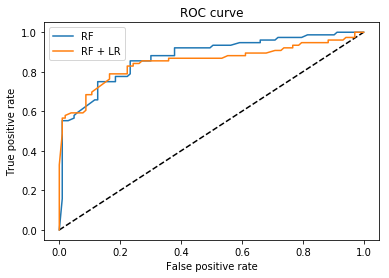

In [20]:
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()